<a href="https://colab.research.google.com/github/OracyC/TMDB-Box-Office-Prediction/blob/master/TMDB_Box_Office_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data



In [0]:
files = "https://github.com/OracyC/TMDB-Box-Office-Prediction/raw/master/tmdb-box-office-prediction.zip" 
!rm -rf * && pip install git+https://github.com/data-8/Gofer-Grader && wget $files && unzip -o tmdb-box-office-prediction.zip

  Cloning https://github.com/data-8/Gofer-Grader to /tmp/pip-req-build-1wpqq1e3
  Running command git clone -q https://github.com/data-8/Gofer-Grader /tmp/pip-req-build-1wpqq1e3
  Created wheel for gofer-grader: filename=gofer_grader-1.0.9-cp36-none-any.whl size=10169 sha256=9c264d7dd851def4468e7c41f265a53a1c967e366d6d9158a75139933ab7543f
  Stored in directory: /tmp/pip-ephem-wheel-cache-vxjbkk1_/wheels/9e/62/24/8563ae039051d6ba979557d1766bfebbda5dd08f8572e3e35d
Successfully built gofer-grader
--2019-12-10 02:41:01--  https://github.com/OracyC/TMDB-Box-Office-Prediction/raw/master/tmdb-box-office-prediction.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/OracyC/TMDB-Box-Office-Prediction/master/tmdb-box-office-prediction.zip [following]
--2019-12-10 02:41:01--  https://raw.githubusercontent.com/OracyC/TMDB-Box-Office-P

In [0]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
trainAdditionalFeatures = pd.read_csv('TrainAdditionalFeatures.csv')
testAdditionalFeatures = pd.read_csv('TestAdditionalFeatures.csv')

train = pd.merge(train, trainAdditionalFeatures, how='left', on=['imdb_id'])
test = pd.merge(test, testAdditionalFeatures, how='left', on=['imdb_id'])

In [0]:
train = train.drop_duplicates()
test = test.drop_duplicates()

# EDA & Feature Engerineering

In [0]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'popularity2', 'rating', 'totalVotes'],
      dtype='object')

In [0]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,popularity2,rating,totalVotes
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,10.400,5.0,482.0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,15.229,6.4,1528.0
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,26.082,8.4,7314.0
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,5.531,7.5,115.0
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,NaN,NaN,NaN


In [0]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,popularity2,rating,totalVotes
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",6.468,6.6,91.0
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",3.649,4.5,51.0
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de...",9.012,6.1,176.0
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de...",10.923,8.0,937.0
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de...",5.692,6.8,50.0


In [0]:
train.describe()

,id,budget,popularity,runtime,revenue,popularity2,rating,totalVotes
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03,2882.000000,2882.000000,2882.000000
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07,8.029303,6.366308,933.938584
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08,4.959153,0.887465,1795.101380
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00,0.600000,1.000000,1.000000
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06,5.046250,5.800000,82.000000
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07,7.503500,6.400000,292.500000
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07,9.987000,7.000000,900.500000
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09,45.153000,9.000000,18931.000000


In [0]:
train.describe(include=['O'])

,belongs_to_collection,genres,homepage,imdb_id,original_language,original_title,overview,poster_path,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,Keywords,cast,crew
count,604,2993,946,3000,3000,3000,2992,2999,2844,2945,3000,2980,3000,2403,3000,2724,2987,2984
unique,422,872,941,3000,36,2975,2992,2999,2383,321,2398,401,2,2400,2969,2648,2975,2984
top,"[{'id': 645, 'name': 'James Bond Collection', ...","[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt1029120,en,Ben-Hur,Six actors portray six personas of music legen...,/yPOg9szzJQpmX4bCP0xaKlo06z5.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/10,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,The Double,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '52fe4e009251416c75148111', 'de..."
freq,16,266,4,1,2575,2,1,1,51,1752,5,1817,2996,3,2,27,13,1


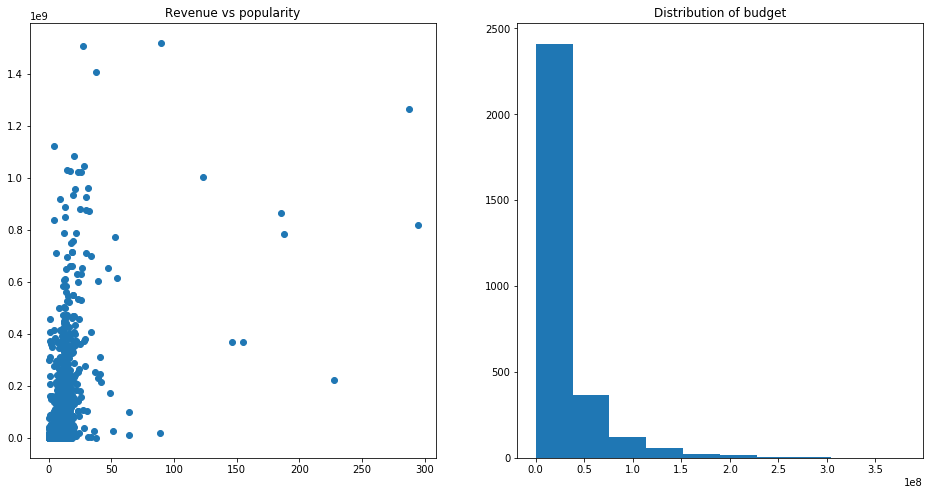

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity');
plt.subplot(1, 2, 2)
plt.hist(train['budget']);
plt.title('Distribution of budget');

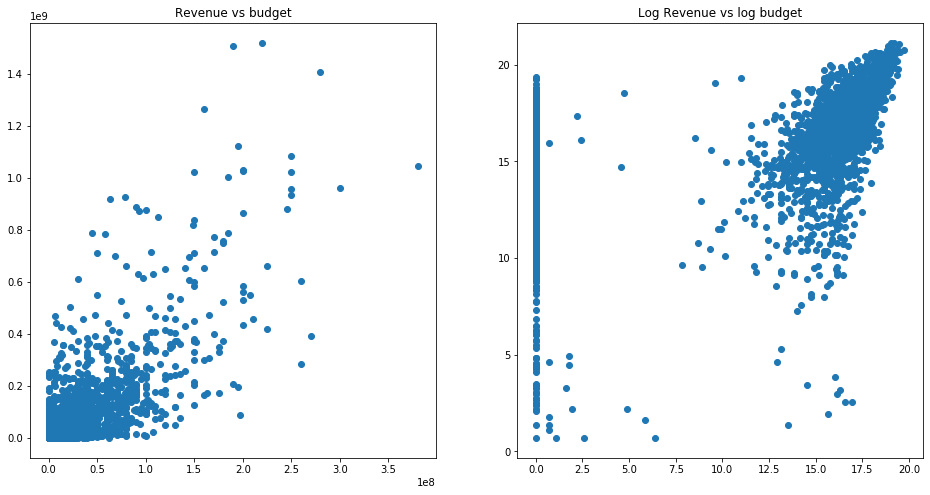

In [0]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), np.log1p(train['revenue']))
plt.title('Log Revenue vs log budget');

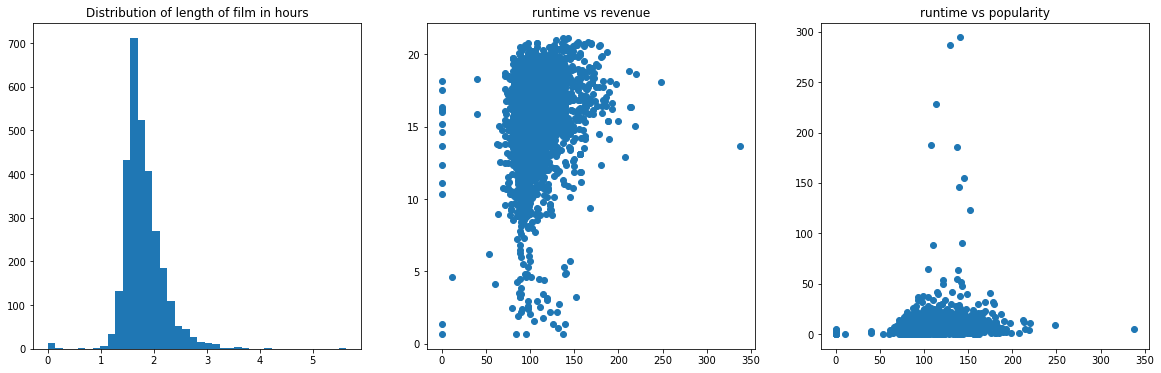

In [0]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), np.log1p(train['revenue']))
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity');

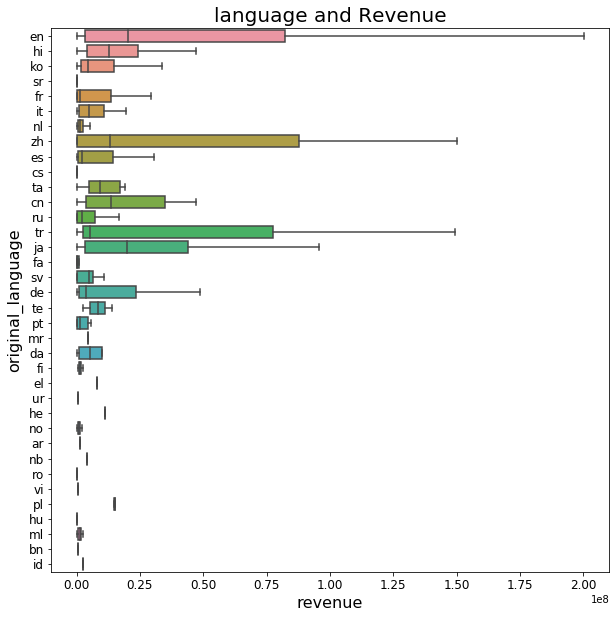

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='both', labelsize=12)
plt.title('language and Revenue', fontsize=20)
plt.xlabel('revenue', fontsize=16)
plt.ylabel('genre', fontsize=16)
sns.boxplot(ax=ax, x=train['revenue'], y=train['original_language'],showfliers=False)
plt.show()

## Feaature Engineering

In [0]:
def proc_json(string, key):
    try:
        data = eval(string)
        return ",".join([d[key] for d in data])
    except:
        return ''

def proc_json_len(string):
    try:
        data = eval(string)
        return len(data)
    except:
        return 0

    
def feature_engineering(df):
    # fill out missing values
    df.runtime.fillna(0, inplace=True)
    df.status.fillna('Released', inplace=True)
    df.release_date.fillna(df.release_date.mode()[0], inplace=True)

    # create count features
    df['count_genre'] = df.genres.apply(proc_json_len)
    df['count_country'] = df.production_countries.apply(proc_json_len)
    df['count_company'] = df.production_companies.apply(proc_json_len)
    df['count_splang'] = df.spoken_languages.apply(proc_json_len)
    df['count_cast'] = df.cast.apply(proc_json_len)
    df['count_crew'] = df.crew.apply(proc_json_len)
    df['count_staff'] = df.count_cast + df.count_crew
    df['count_keyword'] = df.Keywords.apply(proc_json_len)
    
    # convert json features
    df.belongs_to_collection = df.belongs_to_collection.apply(lambda x: proc_json(x, 'name'))
    df.genres = df.genres.apply(lambda x: proc_json(x, 'name'))
    df.production_companies = df.production_companies.apply(lambda x: proc_json(x, 'name'))
    df.production_countries = df.production_countries.apply(lambda x: proc_json(x, 'iso_3166_1'))
    df.spoken_languages = df.spoken_languages.apply(lambda x: proc_json(x, 'iso_639_1'))
    df.Keywords = df.Keywords.apply(lambda x: proc_json(x, 'name'))
    
    # create length of text features
    df['len_title'] = df.title.str.len()
    df.len_title.fillna(0, inplace=True)
    df['len_overview'] = df.overview.str.len()
    df.len_overview.fillna(0, inplace=True)
    df['len_tagline'] = df.tagline.str.len()
    df.len_tagline.fillna(0, inplace=True)
    
    # create date related features
    df.release_date = pd.to_datetime(df.release_date)
    df['release_year'] = df.release_date.dt.year
    df['release_year'] = df.release_year.apply(lambda x: x-100 if x > 2020 else x)
    df['release_month'] = df.release_date.dt.month
    df['release_wday'] = df.release_date.dt.dayofweek

    # create boolean features
    df['in_collection'] = (df.belongs_to_collection != '').astype('uint8')
    df['us_country'] = df.production_countries.str.contains('US').astype('uint8')
    df['en_lang'] = (df.original_language == 'en').astype('uint8')
    df['has_hompage'] = df.homepage.apply(lambda x: 1 if pd.isnull(x) == False else 0)

    # log money values
    if 'revenue' in df.columns:
        df.revenue = np.log1p(df.revenue)
    df.budget = np.log1p(df.budget)
    df.popularity = np.log1p(df.popularity)
    
    return df

In [0]:
train = feature_engineering(train)
test = feature_engineering(test)

## EDA

In [0]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,popularity2,rating,totalVotes,count_genre,count_country,count_company,count_splang,count_cast,count_crew,count_staff,count_keyword,len_title,len_overview,len_tagline,release_year,release_month,release_wday,in_collection,us_country,en_lang,has_hompage
0,1,Hot Tub Time Machine Collection,16.454568,Comedy,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2.024905,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"Paramount Pictures,United Artists,Metro-Goldwy...",US,2015-02-20,93.0,en,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"time travel,sequel,hot tub,duringcreditsstinger","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",16.326300,10.400,5.0,482.0,1,1,3,1,24,72,96,4,22,155.0,52.0,2015,2,4,1,1,1,0
1,2,The Princess Diaries Collection,17.504390,"Comedy,Drama,Family,Romance",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,2.224504,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,Walt Disney Pictures,US,2004-08-06,113.0,en,Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"coronation,duty,marriage,falling in love","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",18.370959,15.229,6.4,1528.0,4,1,1,1,20,9,29,4,40,393.0,60.0,2004,8,4,1,1,1,0
2,3,,15.009433,Drama,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",4.178992,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"Bold Films,Blumhouse Productions,Right of Way ...",US,2014-10-10,105.0,en,Released,The road to greatness can take you to the edge.,Whiplash,"jazz,obsession,conservatory,music teacher,new ...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",16.387512,26.082,8.4,7314.0,1,1,3,1,51,64,115,12,8,130.0,47.0,2014,10,4,0,1,1,1
3,4,,13.997833,"Thriller,Drama",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,1.429099,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,,IN,2012-03-09,122.0,"en,hi",Released,NaN,Kahaani,"mystery,bollywood,police corruption,crime,indi...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16.588099,5.531,7.5,115.0,2,1,0,2,7,3,10,7,7,581.0,0.0,2012,3,4,0,0,0,1
4,5,,0.000000,"Action,Thriller",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,0.764570,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,,KR,2009-02-05,118.0,ko,Released,NaN,Marine Boy,,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",15.182615,NaN,NaN,NaN,2,1,0,1,4,2,6,0,10,168.0,0.0,2009,2,3,0,0,0,0


In [0]:
train.describe()

,id,budget,popularity,runtime,revenue,popularity2,rating,totalVotes,count_genre,count_country,count_company,count_splang,count_cast,count_crew,count_staff,count_keyword,len_title,len_overview,len_tagline,release_year,release_month,release_wday,in_collection,us_country,en_lang,has_hompage
count,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,2882.000000,2882.000000,2882.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,11.878667,1.975396e+00,107.784667,15.961986,8.029303,6.366308,933.938584,2.503667,1.326333,2.698333,1.452333,20.603667,24.365667,44.969333,7.226667,15.159000,307.805667,35.761000,1999.713000,6.775333,3.255667,0.201333,0.760667,0.858333,0.315333
std,866.169729,7.441843,7.416869e-01,22.253944,3.061311,4.959153,0.887465,1795.101380,1.117021,0.752349,2.014121,0.887688,16.629635,28.066419,37.700303,6.665891,8.329196,167.023568,29.041069,15.423313,3.409115,1.325979,0.401063,0.426748,0.348766,0.464726
min,1.000000,0.000000,9.999995e-07,0.000000,0.693147,0.600000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1921.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,750.750000,0.000000,1.613042e+00,94.000000,14.682517,5.046250,5.800000,82.000000,2.000000,1.000000,1.000000,1.000000,11.000000,8.000000,21.000000,3.000000,10.000000,178.000000,17.000000,1993.000000,4.000000,2.000000,0.000000,1.000000,1.000000,0.000000
50%,1500.500000,15.894952,2.125233e+00,104.000000,16.637310,7.503500,6.400000,292.500000,2.000000,1.000000,2.000000,1.000000,16.000000,14.000000,33.000000,6.000000,13.000000,285.000000,32.000000,2004.000000,7.000000,4.000000,0.000000,1.000000,1.000000,0.000000
75%,2250.250000,17.182806,2.475780e+00,118.000000,18.048445,9.987000,7.000000,900.500000,3.000000,1.000000,4.000000,2.000000,24.000000,28.000000,56.000000,10.000000,19.000000,395.250000,50.000000,2011.000000,10.000000,4.000000,0.000000,1.000000,1.000000,1.000000
max,3000.000000,19.755682,5.688117e+00,338.000000,21.141685,45.153000,9.000000,18931.000000,7.000000,8.000000,17.000000,9.000000,156.000000,194.000000,280.000000,149.000000,62.000000,1007.000000,232.000000,2017.000000,12.000000,6.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
train.describe(include=['O'])

,belongs_to_collection,genres,homepage,imdb_id,original_language,original_title,overview,poster_path,production_companies,production_countries,spoken_languages,status,tagline,title,Keywords,cast,crew
count,3000,3000,946,3000,3000,3000,2992,2999,3000,3000,3000,3000,2403,3000,3000,2987,2984
unique,423,873,941,3000,36,2975,2992,2999,2384,322,402,2,2400,2969,2649,2975,2984
top,,Drama,http://www.transformersmovie.com/,tt1029120,en,Ben-Hur,Six actors portray six personas of music legen...,/yPOg9szzJQpmX4bCP0xaKlo06z5.jpg,,US,en,Released,Based on a true story.,The Double,,[],"[{'credit_id': '52fe4e009251416c75148111', 'de..."
freq,2396,266,4,1,2575,2,1,1,156,1752,1817,2996,3,2,276,13,1


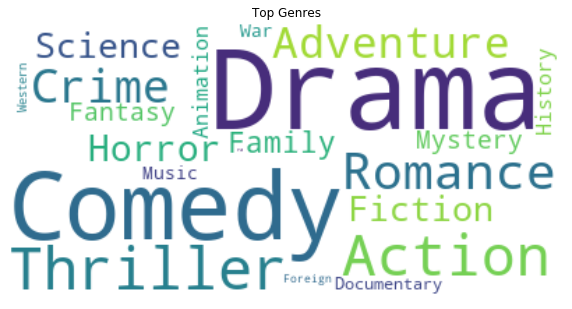

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud_genres = WordCloud(max_font_size=80, max_words=100, background_color="white", collocations=False).generate(train['genres'].to_string())
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud_genres, interpolation="bilinear")
plt.title("Top Genres")
plt.axis("off")
plt.show()

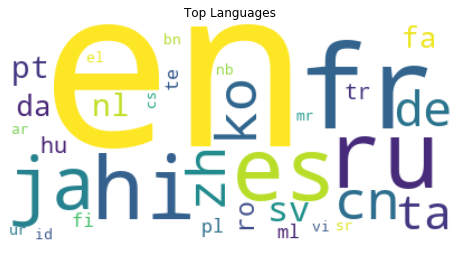

In [0]:
wordcloud_lan = WordCloud(max_font_size=200, max_words=100, background_color="white").generate(train['original_language'].to_string())
plt.figure(figsize = (8, 6))
plt.imshow(wordcloud_lan, interpolation="bilinear")
plt.title("Top Languages")
plt.axis("off")
plt.show()

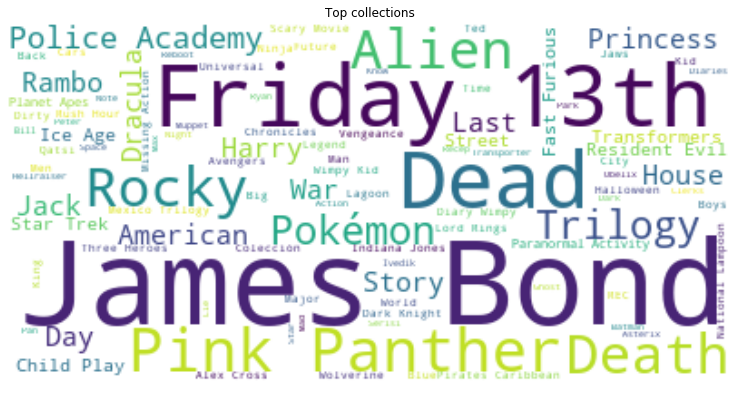

In [0]:
stopwords = set(STOPWORDS)
stopwords.add('collection')
stopwords.add('series')
stopwords.add('original')
wordcloud_lan = WordCloud(max_font_size=150, max_words=100, background_color="white", stopwords = stopwords).generate(train['belongs_to_collection'].to_string())
plt.figure(figsize = (13, 10))
plt.imshow(wordcloud_lan, interpolation="bilinear")
plt.title("Top collections")
plt.axis("off")
plt.show()

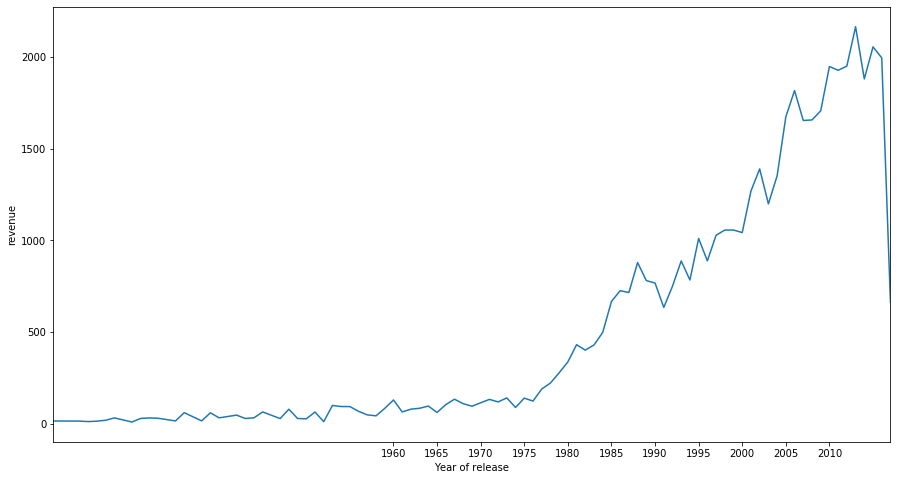

In [0]:
year_plot = train[['revenue', 'release_year']]
money_Y = year_plot.groupby('release_year')['revenue'].sum()

money_Y.plot(figsize=(15,8))
plt.xlabel("Year of release")
plt.ylabel("revenue")
plt.xticks(np.arange(1960,2015,5))

plt.show()

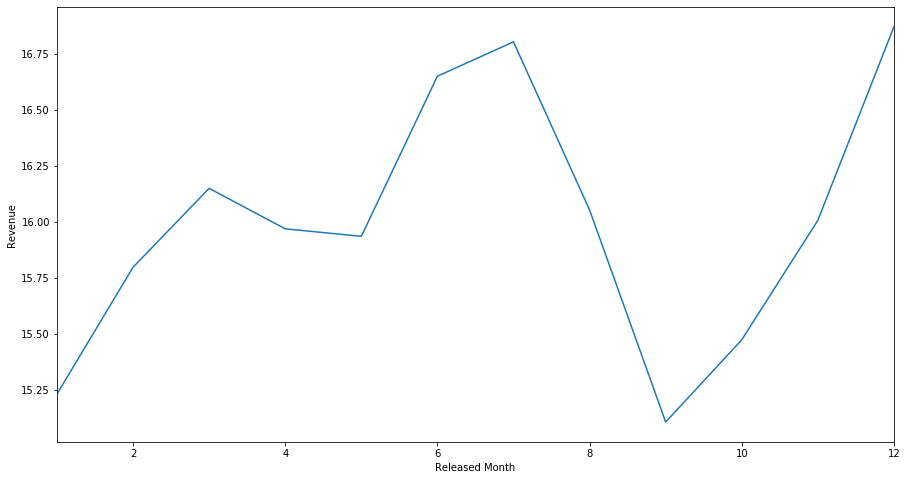

In [0]:
month_plot = train[['revenue', 'release_month']]
money_M = month_plot.groupby('release_month')['revenue'].mean()

money_M.plot(figsize=(15,8))
plt.xlabel("Released Month")
plt.ylabel("Revenue")

plt.show()

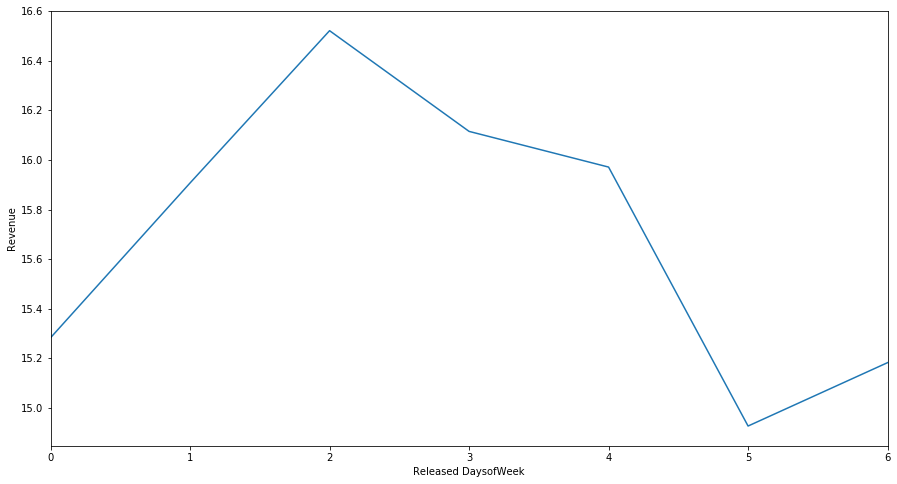

In [0]:
wday_plot = train[['revenue', 'release_wday']]
money_W = wday_plot.groupby('release_wday')['revenue'].mean()

money_W.plot(figsize=(15,8))
plt.xlabel("Released DaysofWeek")
plt.ylabel("Revenue")

plt.show()

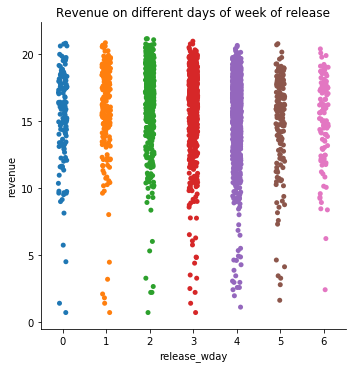

In [0]:
sns.catplot(x='release_wday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

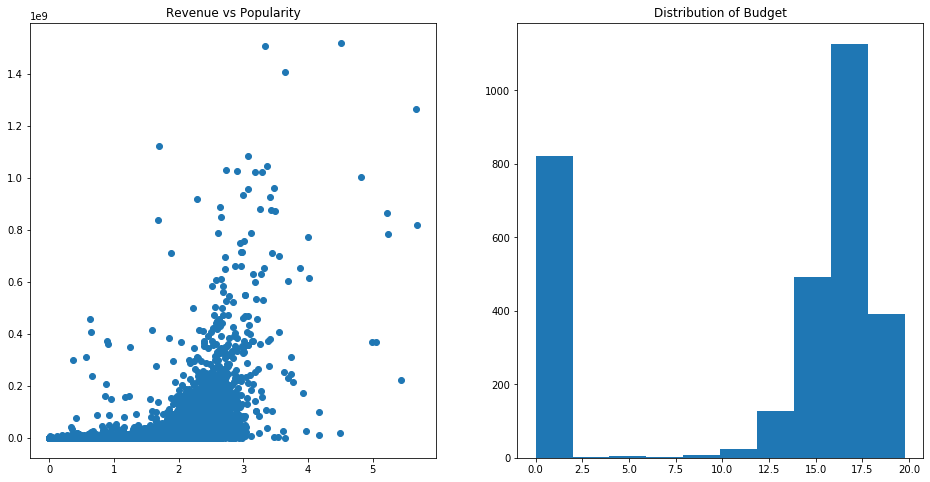

In [0]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], np.expm1(train['revenue'])+1)
plt.title('Revenue vs Popularity');
plt.subplot(1, 2, 2)
plt.hist(train['budget']);
plt.title('Distribution of Budget');

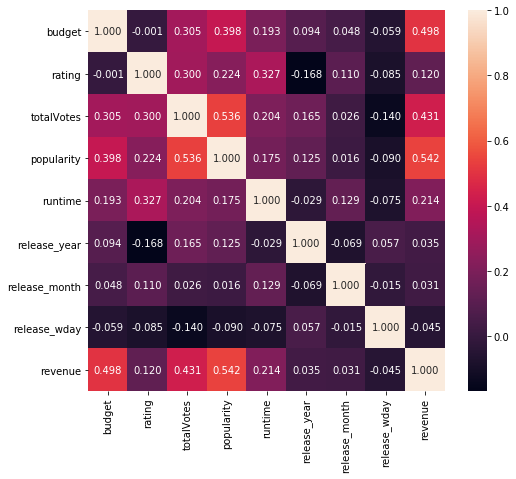

In [0]:
cor_features = train[['budget', 'rating', 'totalVotes', 'popularity', 'runtime',
            'release_year', 'release_month', 'release_wday','revenue']]
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cor_features.corr(), annot=True, linewidths=0, fmt= '.3f',ax=ax)
plt.show()

## Feature Generation

In [0]:
def top_cols_interaction(df):
    df['budget_to_popularity'] = df['budget'] / df['popularity']
    df['rating_to_runtime'] = df['rating'] / df['runtime']
    df['budget_to_totalVotes'] = df['budget'] / df['totalVotes']
    df['totalVotes_to_popularity'] = df['totalVotes'] / df['popularity']
    df['popularity_to_release_year'] = df['popularity'] / df['release_year']
    df['budget_to_release_year'] = df['budget'] / df['release_year']
    df['year_to_budget'] = df['release_year'] / df['budget']

    return df

In [0]:
train = top_cols_interaction(train)
test = top_cols_interaction(test)
train = train.replace([np.inf, -np.inf], 0).fillna(0)
test = test.replace([np.inf, -np.inf], 0).fillna(0)

In [0]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,popularity2,rating,totalVotes,count_genre,count_country,count_company,count_splang,count_cast,count_crew,count_staff,count_keyword,len_title,len_overview,len_tagline,release_year,release_month,release_wday,in_collection,us_country,en_lang,has_hompage,budget_to_popularity,rating_to_runtime,budget_to_totalVotes,totalVotes_to_popularity,popularity_to_release_year,budget_to_release_year,year_to_budget
0,1,Hot Tub Time Machine Collection,16.454568,Comedy,0,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2.024905,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"Paramount Pictures,United Artists,Metro-Goldwy...",US,2015-02-20,93.0,en,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"time travel,sequel,hot tub,duringcreditsstinger","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",16.326300,10.400,5.0,482.0,1,1,3,1,24,72,96,4,22,155.0,52.0,2015,2,4,1,1,1,0,8.126093,0.053763,0.034138,238.035831,0.001005,0.008166,122.458396
1,2,The Princess Diaries Collection,17.504390,"Comedy,Drama,Family,Romance",0,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,2.224504,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,Walt Disney Pictures,US,2004-08-06,113.0,en,Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"coronation,duty,marriage,falling in love","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",18.370959,15.229,6.4,1528.0,4,1,1,1,20,9,29,4,40,393.0,60.0,2004,8,4,1,1,1,0,7.868895,0.056637,0.011456,686.894670,0.001110,0.008735,114.485566
2,3,,15.009433,Drama,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",4.178992,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"Bold Films,Blumhouse Productions,Right of Way ...",US,2014-10-10,105.0,en,Released,The road to greatness can take you to the edge.,Whiplash,"jazz,obsession,conservatory,music teacher,new ...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",16.387512,26.082,8.4,7314.0,1,1,3,1,51,64,115,12,8,130.0,47.0,2014,10,4,0,1,1,1,3.591640,0.080000,0.002052,1750.182868,0.002075,0.007453,134.182281
3,4,,13.997833,"Thriller,Drama",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,1.429099,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,,IN,2012-03-09,122.0,"en,hi",Released,0,Kahaani,"mystery,bollywood,police corruption,crime,indi...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16.588099,5.531,7.5,115.0,2,1,0,2,7,3,10,7,7,581.0,0.0,2012,3,4,0,0,0,1,9.794866,0.061475,0.121720,80.470281,0.000710,0.006957,143.736535
4,5,,0.000000,"Action,Thriller",0,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,0.764570,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,,KR,2009-02-05,118.0,ko,Released,0,Marine Boy,,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",15.182615,0.000,0.0,0.0,2,1,0,1,4,2,6,0,10,168.0,0.0,2009,2,3,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000381,0.000000,0.000000


## Data preparation

In [0]:
#prepare data for training
train_new = train.drop(columns=['id','belongs_to_collection','genres','homepage','imdb_id','original_language'
                ,'original_title','overview','poster_path','production_companies','production_countries'
                ,'release_date','spoken_languages','status','tagline','title','Keywords','cast','crew'])
test_new = test.drop(columns=['id','belongs_to_collection','genres','homepage','imdb_id','original_language'
                ,'original_title','overview','poster_path','production_companies','production_countries'
                ,'release_date','spoken_languages','status','tagline','title','Keywords','cast','crew'])

In [0]:
from sklearn.model_selection  import train_test_split

y = train_new.revenue

X = train_new.drop(columns=['revenue'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2100, 31) (900, 31) (2100,) (900,)


In [0]:
X_train.head()

,budget,popularity,runtime,popularity2,rating,totalVotes,count_genre,count_country,count_company,count_splang,count_cast,count_crew,count_staff,count_keyword,len_title,len_overview,len_tagline,release_year,release_month,release_wday,in_collection,us_country,en_lang,has_hompage,budget_to_popularity,rating_to_runtime,budget_to_totalVotes,totalVotes_to_popularity,popularity_to_release_year,budget_to_release_year,year_to_budget
1732,15.520259,0.811060,140.0,1.593,4.6,14.0,3,1,1,1,10,1,11,0,11,478.0,23.0,2013,9,4,1,0,0,0,19.135761,0.032857,1.108590,17.261353,0.000403,0.007710,129.701445
2441,17.111347,2.497405,110.0,15.082,7.5,2083.0,4,2,6,1,17,16,33,18,19,284.0,38.0,2006,2,4,0,1,1,0,6.851651,0.068182,0.008215,834.065798,0.001245,0.008530,117.232147
1232,0.000000,0.481459,116.0,1.810,5.7,11.0,1,2,7,1,7,14,21,2,15,393.0,0.0,2007,9,2,0,0,1,1,0.000000,0.049138,0.000000,22.847220,0.000240,0.000000,0.000000
1081,16.523561,2.652101,110.0,13.156,7.1,2155.0,5,1,2,1,19,13,32,10,13,373.0,80.0,1987,3,4,1,1,1,0,6.230367,0.064545,0.007668,812.563399,0.001335,0.008316,120.252530
2921,0.000000,0.041176,92.0,0.000,0.0,0.0,3,2,4,1,38,31,69,5,14,490.0,41.0,2000,10,6,0,0,1,0,0.000000,0.000000,0.000000,0.000000,0.000021,0.000000,0.000000


In [0]:
train_new.shape

(3000, 32)

# Modeling

In [0]:
import math

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

# print_score function depending on the evaluation metric: rmse
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
#feature importance to dataframe
def feature_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)
# function to plot feature importance
def plot_fi(fi): return fi.plot('cols','imp','barh', figsize = (10,8), legend=False)

## Base Line Model

In [0]:
train_null = train_new.copy()
train_null['revenue'] = train_null['revenue'].mean()
y_null = train_null['revenue']
rmse_null = rmse(y, y_null)
print("The rmse of the null model is",rmse_null)

The rmse of the null model is 3.0608007087396016


## Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=42, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True, random_state=38)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=42, n_jobs=-1,
                      oob_score=True, random_state=38, verbose=0,
                      warm_start=False)

In [0]:
print('R2 for Train', rf.score( X_train, y_train ))
print_score(rf)

R2 for Train 0.7960852568484699
[1.402470113325094, 1.9521635040242844, 0.7960852568484699, 0.5610437933978231, 0.5430955715025587]


In [0]:
fi = feature_importance(rf, X_train)
fi[-10:]

,cols,imp
2,runtime,0.025052
28,popularity_to_release_year,0.044418
17,release_year,0.055614
1,popularity,0.056785
3,popularity2,0.062757
27,totalVotes_to_popularity,0.062782
30,year_to_budget,0.072828
0,budget,0.075413
5,totalVotes,0.165598
29,budget_to_release_year,0.182271


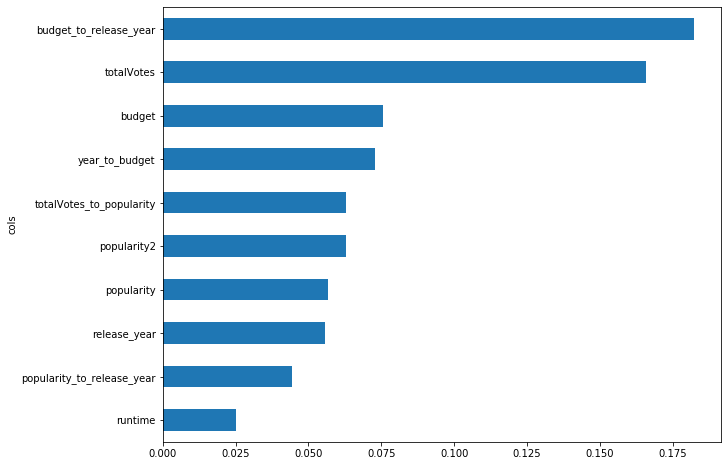

In [0]:
plot_fi(fi[-10:])

In [0]:
new_features = ['budget_to_release_year','totalVotes','budget','year_to_budget','totalVotes_to_popularity','popularity2','popularity','release_year','popularity_to_release_year','runtime']
X_new = train_new[new_features]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new,y,train_size=0.7,test_size=0.3,random_state=0)
rf1 = RandomForestRegressor(n_estimators=42, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True, random_state=38)
rf1.fit(X_train_new, y_train_new)
print([rmse(rf1.predict(X_train_new), y_train_new),rmse(rf1.predict(X_test_new),y_test_new),rf1.score(X_train_new, y_train_new), rf1.score(X_test_new, y_test_new)])

[1.5232157269173434, 1.9908199230514043, 0.7594617060263393, 0.5434873966197933]


## LightGBM Regression

In [0]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(objective='regression',num_leaves=8,
                              learning_rate=0.05, n_estimators=650,
                              max_bin=58, bagging_fraction=0.80,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=7, min_sum_hessian_in_leaf=11)


In [0]:
lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=10)
print_score(lgbm)

[1]	valid_0's l1: 2.17506	valid_0's l2: 8.45647
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 2.12138	valid_0's l2: 8.11595
[3]	valid_0's l1: 2.07064	valid_0's l2: 7.76696
[4]	valid_0's l1: 2.02279	valid_0's l2: 7.47065
[5]	valid_0's l1: 1.99034	valid_0's l2: 7.27123
[6]	valid_0's l1: 1.95124	valid_0's l2: 7.03755
[7]	valid_0's l1: 1.91423	valid_0's l2: 6.80012
[8]	valid_0's l1: 1.88329	valid_0's l2: 6.60263
[9]	valid_0's l1: 1.85081	valid_0's l2: 6.41907
[10]	valid_0's l1: 1.82168	valid_0's l2: 6.25494
[11]	valid_0's l1: 1.79102	valid_0's l2: 6.08627
[12]	valid_0's l1: 1.76063	valid_0's l2: 5.9314
[13]	valid_0's l1: 1.74525	valid_0's l2: 5.84544
[14]	valid_0's l1: 1.72263	valid_0's l2: 5.72726
[15]	valid_0's l1: 1.69548	valid_0's l2: 5.59197
[16]	valid_0's l1: 1.67522	valid_0's l2: 5.49134
[17]	valid_0's l1: 1.6655	valid_0's l2: 5.43579
[18]	valid_0's l1: 1.64509	valid_0's l2: 5.33103
[19]	valid_0's l1: 1.63579	valid_0's l2: 5.28136
[20]	valid_0's l1:

In [0]:
booster = lgbm.booster_
importance = booster.feature_importance(importance_type='split')
feature_name = booster.feature_name()
feature_importance = pd.DataFrame({'cols':feature_name,'imp':importance} ).sort_values('imp', ascending=True)
feature_importance

,cols,imp
23,has_hompage,0
9,count_splang,1
7,count_country,7
22,en_lang,11
21,us_country,12
6,count_genre,15
8,count_company,15
11,count_crew,17
13,count_keyword,19
20,in_collection,20


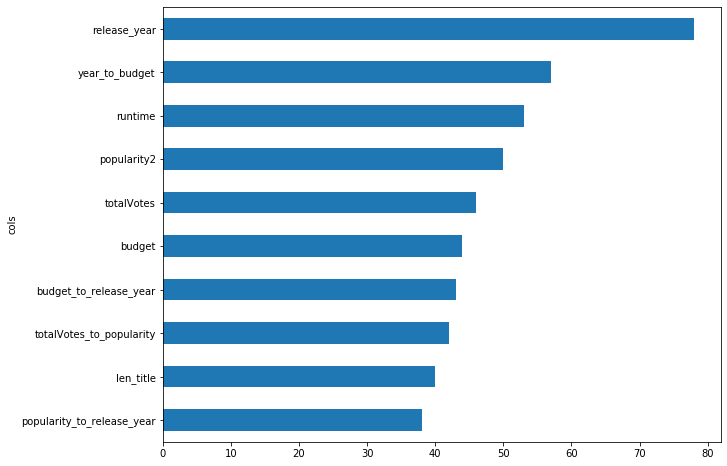

In [0]:
plot_fi(feature_importance[-10:])

In [0]:
new_features1 = ['release_year','year_to_budget','runtime','popularity2','totalVotes','budget','budget_to_release_year','totalVotes_to_popularity','len_title','popularity_to_release_year']
X_new1 = train_new[new_features1]
X_train_new1, X_test_new1, y_train_new1, y_test_new1 = train_test_split(X_new1,y,train_size=0.7,test_size=0.3,random_state=0)
lgbm1 = lgb.LGBMRegressor(objective='regression',num_leaves=8,
                              learning_rate=0.05, n_estimators=650,
                              max_bin=58, bagging_fraction=0.80,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=7, min_sum_hessian_in_leaf=11)
lgbm1.fit(X_train_new1, y_train_new1, eval_set=[(X_test_new1, y_test_new1)],eval_metric='l1',early_stopping_rounds=10)
print([rmse(lgbm1.predict(X_train_new1), y_train_new1),rmse(lgbm1.predict(X_test_new1),y_test_new1),lgbm1.score(X_train_new1, y_train_new1), lgbm1.score(X_test_new1, y_test_new1)])

[1]	valid_0's l1: 2.17266	valid_0's l2: 8.43689
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 2.13201	valid_0's l2: 8.17304
[3]	valid_0's l1: 2.09904	valid_0's l2: 7.95597
[4]	valid_0's l1: 2.05769	valid_0's l2: 7.6897
[5]	valid_0's l1: 2.0203	valid_0's l2: 7.44775
[6]	valid_0's l1: 1.9794	valid_0's l2: 7.17956
[7]	valid_0's l1: 1.94141	valid_0's l2: 6.94581
[8]	valid_0's l1: 1.9066	valid_0's l2: 6.72808
[9]	valid_0's l1: 1.87742	valid_0's l2: 6.55787
[10]	valid_0's l1: 1.85534	valid_0's l2: 6.42942
[11]	valid_0's l1: 1.83359	valid_0's l2: 6.3088
[12]	valid_0's l1: 1.8024	valid_0's l2: 6.13974
[13]	valid_0's l1: 1.78434	valid_0's l2: 6.04213
[14]	valid_0's l1: 1.75717	valid_0's l2: 5.9008
[15]	valid_0's l1: 1.73406	valid_0's l2: 5.77455
[16]	valid_0's l1: 1.70984	valid_0's l2: 5.64441
[17]	valid_0's l1: 1.69024	valid_0's l2: 5.53716
[18]	valid_0's l1: 1.67312	valid_0's l2: 5.44426
[19]	valid_0's l1: 1.66002	valid_0's l2: 5.37712
[20]	valid_0's l1: 1.64

## Grid Search

In [0]:
!pip install catboost

     |████████████████████████████████| 63.6MB 35kB/s 


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import time
from tqdm import tqdm

def select_model(X, Y):

    best_models = {}
    models = [
        {   'name': 'LinearRegression',
            'estimator': LinearRegression() 
        },
        {   'name': 'KNeighborsRegressor',
            'estimator': KNeighborsRegressor(),
        },
        {   'name': 'RandomForestRegressor',
            'estimator': RandomForestRegressor(),
        },
        {   'name': 'MLPRegressor',
            'estimator': MLPRegressor(),
        },
        {   'name': 'GradientBoostingRegressor',
            'estimator': GradientBoostingRegressor(),
        },
        {   'name': 'XGBoost',
            'estimator': XGBRegressor(),
        },
        {   'name': 'LightGBM',
            'estimator': LGBMRegressor(),
        },
        {   'name': 'CatBoost',
            'estimator': CatBoostRegressor(verbose=False),
        }
        
    ]
    
    for model in tqdm(models):
        start = time.perf_counter()
        grid = GridSearchCV(model['estimator'], param_grid={}, cv=5, scoring = "neg_mean_squared_error", verbose=False, n_jobs=-1)
        grid.fit(X, Y)
        best_models[model['name']] = {'score': grid.best_score_, 'params': grid.best_params_, 'model':model['estimator']}
        run = time.perf_counter() - start
        
    return best_models

models = select_model(train_new.drop(['revenue'],axis=1), train_new['revenue'])
models

 25%|██▌       | 2/8 [00:04<00:14,  2.34s/it]/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
 62%|██████▎   | 5/8 [00:23<00:14,  4.88s/it]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:35:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 8/8 [01:05<00:00, 13.43s/it]


{'CatBoost': {'model': <catboost.core.CatBoostRegressor at 0x7f85ded72128>,
  'params': {},
  'score': -4.022992231764873},
 'GradientBoostingRegressor': {'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='ls', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='auto',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0, warm_start=False),
  'params': {},
  'score': -4.1899421936055585},
 'KNeighborsRegressor': {'model': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                   

In [0]:
best_model = None
max_score = -100
best_model_name = ''

for m in models:
    if models[m]['score'] > max_score:
        max_score = models[m]['score']
        best_model = models[m]['model']
        best_model_name = m
        
print(best_model_name, max_score)

CatBoost -4.022992231764873


## CatBoost Regression

In [0]:
cat = CatBoostRegressor()
cat.fit(train_new.drop(['revenue'],axis=1), train_new['revenue'])
print_score(cat)

0:	learn: 3.0230391	total: 5.78ms	remaining: 5.78s
1:	learn: 2.9852445	total: 11.4ms	remaining: 5.68s
2:	learn: 2.9490416	total: 16.8ms	remaining: 5.59s
3:	learn: 2.9150545	total: 23.4ms	remaining: 5.83s
4:	learn: 2.8829841	total: 29.1ms	remaining: 5.79s
5:	learn: 2.8523091	total: 34.4ms	remaining: 5.7s
6:	learn: 2.8218226	total: 39.6ms	remaining: 5.62s
7:	learn: 2.7892277	total: 45ms	remaining: 5.58s
8:	learn: 2.7613857	total: 50.3ms	remaining: 5.54s
9:	learn: 2.7324138	total: 55.4ms	remaining: 5.48s
10:	learn: 2.7063871	total: 60.5ms	remaining: 5.44s
11:	learn: 2.6814887	total: 65.6ms	remaining: 5.4s
12:	learn: 2.6563864	total: 70.6ms	remaining: 5.36s
13:	learn: 2.6305008	total: 75.6ms	remaining: 5.32s
14:	learn: 2.6060313	total: 81ms	remaining: 5.32s
15:	learn: 2.5838714	total: 86.4ms	remaining: 5.31s
16:	learn: 2.5604630	total: 91.6ms	remaining: 5.3s
17:	learn: 2.5386346	total: 97.1ms	remaining: 5.3s
18:	learn: 2.5192829	total: 102ms	remaining: 5.29s
19:	learn: 2.5011280	total: 108

## XGBoost Regression

In [0]:
xgb = XGBRegressor(learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=100)
xgb.fit(train_new.drop(['revenue'],axis=1), train_new['revenue'], eval_metric='rmse')
print_score(xgb)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[1.573009889383801, 1.5315707468505426, 0.7434781860696855, 0.729813938384453]


# Prepare Submission

In [0]:
#prepare data for submission

predictions = np.expm1(xgb.predict(test_new))

In [0]:
sub = pd.read_csv('sample_submission.csv')
sub['revenue'] = np.round(predictions)
sub.head()

,id,revenue
0,3001,3079230.0
1,3002,767272.0
2,3003,6937200.0
3,3004,15225564.0
4,3005,624502.0


In [0]:
sub.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')